In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
pip install img2vec_pytorch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [6]:
# Update these paths according to your setup
INPUT_IMAGES_PATH = "/content/drive/MyDrive/input_images"  # Directory containing the input images
CROPS_PATH = "/content/data/base/crops/object"
OUTPUT_PATH = "/content/drive/MyDrive/clustered_images"

# YOLO Configuration
YOLO_MODEL = "/content/drive/MyDrive/Cv_project/models/individual_products.pt"
CONFIDENCE_THRESHOLD = 0.5

print(f"Input images path: {INPUT_IMAGES_PATH}")
print(f"Crops will be saved to: {CROPS_PATH}")
print(f"Clustered results will be saved to: {OUTPUT_PATH}")
print(f"YOLO model: {YOLO_MODEL}")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")

Input images path: /content/drive/MyDrive/input_images
Crops will be saved to: /content/data/base/crops/object
Clustered results will be saved to: /content/drive/MyDrive/clustered_images
YOLO model: /content/drive/MyDrive/Cv_project/models/individual_products.pt
Confidence threshold: 0.5


In [7]:
# Helper Functions
def find_optimal_clusters(embeddings, max_clusters=8):
    """Find optimal number of clusters using elbow method."""
    if len(embeddings) < 2:
        return 1

    max_k = min(max_clusters, len(embeddings))
    if max_k < 2:
        return 1

    inertias = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(embeddings)
        inertias.append(kmeans.inertia_)

    # Simple elbow detection
    if len(inertias) < 3:
        return 2

    # Calculate the rate of change
    deltas = [inertias[i] - inertias[i+1] for i in range(len(inertias)-1)]

    # Find the elbow point
    if len(deltas) >= 2:
        delta_deltas = [deltas[i] - deltas[i+1] for i in range(len(deltas)-1)]
        elbow_idx = delta_deltas.index(min(delta_deltas)) + 2
        return min(elbow_idx, max_k)

    return 2

def add_cluster_circles(ax, embeddings, labels, alpha=0.2):
    """Add circular regions around clusters."""
    colors = plt.cm.Set3(np.linspace(0, 1, len(np.unique(labels))))

    for i, color in enumerate(colors):
        cluster_points = embeddings[labels == i]
        if len(cluster_points) > 1:
            center = np.mean(cluster_points, axis=0)
            distances = np.sqrt(np.sum((cluster_points - center)**2, axis=1))
            radius = np.max(distances) * 1.2

            circle = plt.Circle(center, radius, color=color, alpha=alpha, fill=True)
            ax.add_patch(circle)

    return colors

def show_images(x, y, images, ax, zoom=0.05):
    """Display thumbnail images on the scatter plot."""
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox

    for i, (xi, yi) in enumerate(zip(x, y)):
        if i < len(images):
            try:
                im = OffsetImage(images[i], zoom=zoom)
                ab = AnnotationBbox(im, (xi, yi), xycoords='data', frameon=False)
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding image {i}: {e}")

In [8]:
# YOLO Detection on Multiple Images
def run_yolo_detection(input_dir, output_dir, model_path="yolov8n.pt", confidence=0.5):
    """
    Run YOLO detection on multiple images and save cropped objects to a single directory.
    """
    # Load YOLO model
    print("Loading YOLO model...")
    model = YOLO(model_path)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get all image files from input directory
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff', '*.webp']
    image_files = []

    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_dir, '**', ext), recursive=True))
        image_files.extend(glob.glob(os.path.join(input_dir, '**', ext.upper()), recursive=True))

    if not image_files:
        print(f"No images found in {input_dir}")
        return

    print(f"Found {len(image_files)} images to process")

    crop_counter = 0

    # Process each image
    for image_path in tqdm(image_files, desc="Processing images"):
        try:
            # Run YOLO detection
            results = model(image_path, conf=confidence)

            # Get the original image filename (without extension)
            base_filename = os.path.splitext(os.path.basename(image_path))[0]

            # Process each detection result
            for result in results:
                boxes = result.boxes
                if boxes is not None:
                    # Load original image
                    original_img = Image.open(image_path)

                    # Process each detected box
                    for i, box in enumerate(boxes):
                        # Get bounding box coordinates
                        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()

                        # Crop the image
                        cropped_img = original_img.crop((int(x1), int(y1), int(x2), int(y2)))

                        # Generate unique filename for the crop
                        crop_filename = f"{base_filename}_crop_{crop_counter:06d}.jpg"
                        crop_path = os.path.join(output_dir, crop_filename)

                        # Save the cropped image
                        cropped_img.save(crop_path, "JPEG", quality=95)
                        crop_counter += 1

                    original_img.close()

        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            continue

    print(f"YOLO detection completed! Saved {crop_counter} cropped objects to {output_dir}")

# Run YOLO detection
print("Starting YOLO detection on multiple images...")
run_yolo_detection(INPUT_IMAGES_PATH, CROPS_PATH, YOLO_MODEL, CONFIDENCE_THRESHOLD)

Starting YOLO detection on multiple images...
Loading YOLO model...
Found 11 images to process


Processing images:   0%|          | 0/11 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0016.jpg: 480x640 51 objects, 58.7ms
Speed: 15.4ms preprocess, 58.7ms inference, 374.3ms postprocess per image at shape (1, 3, 480, 640)


Processing images:   9%|▉         | 1/11 [00:08<01:27,  8.71s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0017.jpg: 480x640 59 objects, 27.9ms
Speed: 2.9ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  18%|█▊        | 2/11 [00:09<00:36,  4.10s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0019.jpg: 480x640 81 objects, 27.9ms
Speed: 2.5ms preprocess, 27.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  27%|██▋       | 3/11 [00:10<00:21,  2.63s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0020.jpg: 480x640 84 objects, 28.0ms
Speed: 2.7ms preprocess, 28.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  36%|███▋      | 4/11 [00:11<00:13,  1.92s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0021.jpg: 480x640 58 objects, 27.9ms
Speed: 2.5ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  45%|████▌     | 5/11 [00:12<00:09,  1.53s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0022.jpg: 480x640 58 objects, 28.0ms
Speed: 2.5ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  55%|█████▍    | 6/11 [00:12<00:06,  1.28s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0023.jpg: 480x640 64 objects, 27.9ms
Speed: 2.6ms preprocess, 27.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  64%|██████▎   | 7/11 [00:13<00:04,  1.14s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0024.jpg: 480x640 65 objects, 27.9ms
Speed: 2.8ms preprocess, 27.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  73%|███████▎  | 8/11 [00:14<00:03,  1.07s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0026.jpg: 480x640 43 objects, 28.0ms
Speed: 4.1ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  82%|████████▏ | 9/11 [00:15<00:02,  1.03s/it]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0027.jpg: 480x640 42 objects, 28.0ms
Speed: 4.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images:  91%|█████████ | 10/11 [00:16<00:00,  1.02it/s]


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0031.jpg: 480x640 52 objects, 28.0ms
Speed: 4.1ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing images: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]

YOLO detection completed! Saved 657 cropped objects to /content/data/base/crops/object


In [9]:
# Check if paths exist
if not os.path.exists(CROPS_PATH):
    print(f"Warning: {CROPS_PATH} does not exist. YOLO detection may have failed.")
else:
    # Get list of cropped images
    list_imgs = glob.glob(f"{CROPS_PATH}/**/*.jpg", recursive=True)
    print(f"Found {len(list_imgs)} cropped images for clustering")

    if len(list_imgs) == 0:
        print(f"No images found in {CROPS_PATH}. Please check the YOLO detection step.")
    else:
        print("Sample crop files:")
        for i, img_path in enumerate(list_imgs[:5]):  # Show first 5 files
            print(f"  {i+1}. {os.path.basename(img_path)}")
        if len(list_imgs) > 5:
            print(f"  ... and {len(list_imgs) - 5} more files")

Found 657 cropped images for clustering
Sample crop files:
  1. IMG-20250609-WA0019_crop_000129.jpg
  2. IMG-20250609-WA0027_crop_000593.jpg
  3. IMG-20250609-WA0031_crop_000633.jpg
  4. IMG-20250609-WA0017_crop_000064.jpg
  5. IMG-20250609-WA0020_crop_000197.jpg
  ... and 652 more files


In [10]:
# Load Image Feature Extraction Model
img2vec = None  # Initialize to None

try:
    # Try img2vec_pytorch first
    try:
        from img2vec_pytorch import Img2Vec
        print("Using Img2Vec from img2vec_pytorch")
        img2vec = Img2Vec(cuda=torch.cuda.is_available())
        print("Img2Vec loaded successfully!")
    except ImportError:
        try:
            from img2vec_pytorch import Img2VecResnet18
            print("Using Img2VecResnet18 from img2vec_pytorch")
            img2vec = Img2VecResnet18(cuda=torch.cuda.is_available())
            print("Img2VecResnet18 loaded successfully!")
        except ImportError:
            print("img2vec_pytorch not available, creating custom ResNet18 extractor...")
            raise ImportError("Fallback to custom implementation")

except (ImportError, Exception) as e:
    print(f"Creating custom ResNet18 feature extractor: {e}")

    # Create custom ResNet18 feature extractor
    import torch
    import torchvision.transforms as transforms
    import torchvision.models as models

    # Load pre-trained ResNet model
    model = models.resnet18(pretrained=True)
    model.eval()

    # Remove the final classification layer to get features
    feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

    # Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create a wrapper class for consistency
    class CustomImg2Vec:
        def __init__(self, model, preprocess):
            self.model = model
            self.preprocess = preprocess
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            self.model.to(self.device)

        def get_vec(self, img):
            """Extract feature vector from PIL Image"""
            with torch.no_grad():
                # Preprocess the image
                input_tensor = self.preprocess(img).unsqueeze(0).to(self.device)
                # Extract features
                features = self.model(input_tensor)
                # Flatten and return as numpy array
                return features.flatten().cpu().numpy()

    img2vec = CustomImg2Vec(feature_extractor, preprocess)
    print("Custom ResNet18 feature extractor created successfully!")

# Convert Images to Feature Vectors
allVectors = {}

# Get list of images with proper recursive search
list_imgs = glob.glob(f"{CROPS_PATH}/**/*.jpg", recursive=True)

if len(list_imgs) == 0:
    print(f"No images found in {CROPS_PATH}. Please run YOLO detection first.")
else:
    print(f"Converting {len(list_imgs)} images to feature vectors...")

    # Function to get feature vector based on the model type
    def get_feature_vector(model, image):
        """Get feature vector using the appropriate method based on model type"""
        if hasattr(model, 'get_vec'):
            return model.get_vec(image)
        elif hasattr(model, 'getVec'):
            return model.getVec(image)
        else:
            raise AttributeError(f"Model doesn't have a recognized feature extraction method")

    # Process images with better error handling
    successful_count = 0
    failed_count = 0

    for image_path in tqdm(list_imgs, desc="Processing crops"):
        try:
            # Open and preprocess the image
            with Image.open(image_path) as img:
                # Convert to RGB if necessary
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                # Get the feature vector
                vec = get_feature_vector(img2vec, img)

                # Store the feature vector
                allVectors[image_path] = vec
                successful_count += 1

        except Exception as e:
            print(f"Error processing {os.path.basename(image_path)}: {e}")
            failed_count += 1
            continue

    print(f"Successfully processed {successful_count} images")
    if failed_count > 0:
        print(f"Failed to process {failed_count} images")

    if successful_count == 0:
        print("No images were successfully processed. Please check your setup.")
    else:
        print(f"Feature extraction complete! Ready for clustering with {len(allVectors)} feature vectors.")

Using Img2Vec from img2vec_pytorch
Creating custom ResNet18 feature extractor: name 'torch' is not defined


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Custom ResNet18 feature extractor created successfully!
Converting 657 images to feature vectors...


Processing crops: 100%|██████████| 657/657 [00:05<00:00, 121.97it/s]

Successfully processed 657 images
Feature extraction complete! Ready for clustering with 657 feature vectors.


In [11]:
# Dimensionality Reduction with t-SNE
if len(allVectors) == 0:
    print("No images were processed successfully. Cannot proceed with clustering.")
else:
    embeddings = np.array(list(allVectors.values()))

    # Perform t-SNE dimensionality reduction on the vector representations
    print("Performing t-SNE dimensionality reduction...")
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(30, len(embeddings)-1))
    embeddings_tsne = tsne.fit_transform(embeddings)

    print(f"t-SNE completed. Shape: {embeddings_tsne.shape}")

Performing t-SNE dimensionality reduction...
t-SNE completed. Shape: (657, 3)


In [12]:
# Clustering Analysis
if len(allVectors) > 0:
    # Perform clustering on t-SNE embeddings
    print("Performing clustering...")
    optimal_k = find_optimal_clusters(embeddings_tsne, max_clusters=8)
    print(f"Optimal number of clusters: {optimal_k}")
    # optimal_k = 7

    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings_tsne)

    # Display cluster sizes
    print("\nCluster sizes:")
    for i in range(optimal_k):
        cluster_size = np.sum(cluster_labels == i)
        print(f"Cluster {i}: {cluster_size} images")

Performing clustering...
Optimal number of clusters: 7

Cluster sizes:
Cluster 0: 79 images
Cluster 1: 136 images
Cluster 2: 128 images
Cluster 3: 48 images
Cluster 4: 103 images
Cluster 5: 81 images
Cluster 6: 82 images


In [13]:
# Create Thumbnails for Visualization
if len(allVectors) > 0:
    # Create an empty list to store the thumbnail images
    images = []

    print("Creating thumbnails for visualization...")
    # Iterate over all crop images
    for image in tqdm(list_imgs, desc="Creating thumbnails"):
        try:
            # Open each image file
            I = Image.open(image)
            # Convert to RGB if necessary
            if I.mode != 'RGB':
                I = I.convert('RGB')
            # Resize the image to a thumbnail size of [100, 100] using Lanczos resampling
            I.thumbnail([100, 100], Image.Resampling.LANCZOS)
            # Append the resized image to the images list
            images.append(I)
        except Exception as e:
            print(f"Error creating thumbnail for {image}: {e}")
            # Add a placeholder or skip
            continue

    print(f"Created {len(images)} thumbnails")

Creating thumbnails for visualization...


Creating thumbnails: 100%|██████████| 657/657 [00:00<00:00, 1926.53it/s]

Created 657 thumbnails


Creating visualization...
Images overlaid on scatter plot


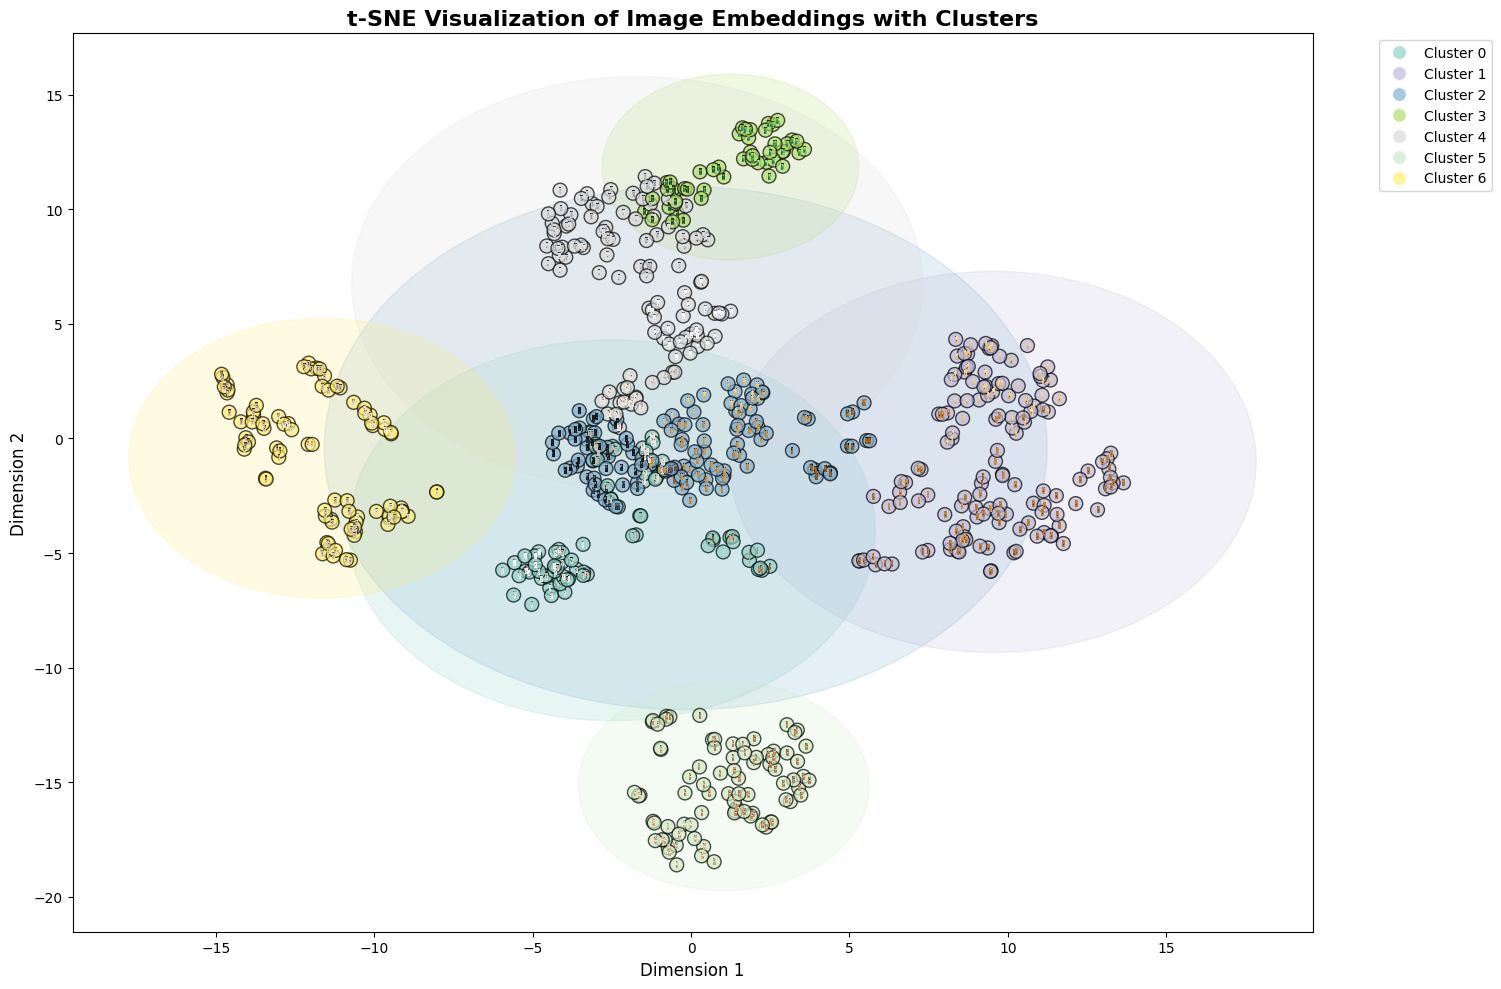

In [14]:
# Create Visualization
if len(allVectors) > 0:
    # Create a scatter plot to visualize the t-SNE embeddings
    print("Creating visualization...")
    fig, ax = plt.subplots(figsize=(15, 10))

    # Add cluster circles first (so they appear behind the images)
    colors = add_cluster_circles(ax, embeddings_tsne, cluster_labels, alpha=0.2)

    # Create scatter plot with cluster colors
    scatter = ax.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                        c=cluster_labels, cmap='Set3', s=100, alpha=0.7,
                        edgecolors='black', linewidth=1)

    # Call the function to display the images on the scatter plot
    if len(images) == len(embeddings_tsne):
        show_images(embeddings_tsne[:, 0], embeddings_tsne[:, 1], images, ax)
        print("Images overlaid on scatter plot")
    else:
        print(f"Warning: Mismatch between embeddings ({len(embeddings_tsne)}) and images ({len(images)})")

    # Set the title and labels for the plot
    ax.set_title('t-SNE Visualization of Image Embeddings with Clusters', fontsize=16, fontweight='bold')
    ax.set_xlabel('Dimension 1', fontsize=12)
    ax.set_ylabel('Dimension 2', fontsize=12)

    # Add legend for clusters
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=colors[i], markersize=10, alpha=0.7,
                         label=f'Cluster {i}')
              for i in range(len(np.unique(cluster_labels)))]

    ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.15, 1))

    # Display the plot
    plt.tight_layout()
    plt.show()

In [15]:
# Save Clustered Images to Folders
if len(allVectors) > 0:
    print(f"\nCluster Analysis and Saving:")

    # Create output directory if it doesn't exist
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    # Get image paths list for organizing clusters
    image_paths = list(allVectors.keys())

    for i in range(len(np.unique(cluster_labels))):
        cluster_size = np.sum(cluster_labels == i)
        print(f"\nCluster {i}: {cluster_size} images")

        # Create cluster folder with automatic naming
        cluster_name = f"product{i+1}"
        cluster_folder = os.path.join(OUTPUT_PATH, cluster_name)
        os.makedirs(cluster_folder, exist_ok=True)

        # Copy images belonging to this cluster
        cluster_indices = np.where(cluster_labels == i)[0]
        copied_count = 0

        for idx in cluster_indices:
            if idx < len(image_paths):
                src_path = image_paths[idx]
                if os.path.exists(src_path):
                    # Get the original filename
                    filename = os.path.basename(src_path)
                    dst_path = os.path.join(cluster_folder, filename)

                    try:
                        # Copy the image to the cluster folder
                        shutil.copy2(src_path, dst_path)
                        copied_count += 1
                    except Exception as e:
                        print(f"Error copying {src_path}: {e}")

        print(f"  → Saved {copied_count} images to '{cluster_folder}'")

    print(f"\nAll clustered images saved to: {OUTPUT_PATH}")


Cluster Analysis and Saving:

Cluster 0: 79 images
  → Saved 79 images to '/content/drive/MyDrive/clustered_images/product1'

Cluster 1: 136 images
  → Saved 136 images to '/content/drive/MyDrive/clustered_images/product2'

Cluster 2: 128 images
  → Saved 128 images to '/content/drive/MyDrive/clustered_images/product3'

Cluster 3: 48 images
  → Saved 48 images to '/content/drive/MyDrive/clustered_images/product4'

Cluster 4: 103 images
  → Saved 103 images to '/content/drive/MyDrive/clustered_images/product5'

Cluster 5: 81 images
  → Saved 81 images to '/content/drive/MyDrive/clustered_images/product6'

Cluster 6: 82 images
  → Saved 82 images to '/content/drive/MyDrive/clustered_images/product7'

All clustered images saved to: /content/drive/MyDrive/clustered_images


# YOLO + CNN Fine-Grained Classification Pipeline

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import glob
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import time

In [36]:
class SubclassDataset(Dataset):
    """Custom dataset for training the CNN classifier on subclasses"""

    def __init__(self, image_paths, labels, transform=None, class_names=None):
        print(f"Initializing dataset with {len(image_paths)} images...")
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.class_names = class_names or [f"class_{i}" for i in range(len(set(labels)))]

        # Quick validation - don't check every image to avoid hanging
        print("Dataset initialized successfully!")
        print(f"Total images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a blank image and label as fallback
            blank_image = Image.new('RGB', (224, 224), color='white')
            if self.transform:
                blank_image = self.transform(blank_image)
            return blank_image, label

class LightweightCNN(nn.Module):
    """Lightweight CNN classifier optimized for small datasets"""

    def __init__(self, num_classes):
        super(LightweightCNN, self).__init__()

        # Much simpler architecture
        self.features = nn.Sequential(
            # First block
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 224 -> 112

            # Second block
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 112 -> 56

            # Third block
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),  # 56 -> 28

            # Global Average Pooling instead of large FC layer
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Much smaller classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

def get_transforms(input_size=224):
    """Get optimized data transforms"""

    train_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_transform

def count_parameters(model):
    """Count the number of trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_lightweight_cnn(train_dataset, val_dataset, num_classes, epochs=15, batch_size=16, lr=0.001):
    """Train the lightweight CNN classifier with extensive debugging"""

    print("=" * 50)
    print("STARTING CNN TRAINING")
    print("=" * 50)

    try:
        print(f"Training dataset size: {len(train_dataset)}")
        print(f"Validation dataset size: {len(val_dataset)}")
        print(f"Number of classes: {num_classes}")

        # Test dataset access
        print("Testing dataset access...")
        try:
            sample_img, sample_label = train_dataset[0]
            print(f"Sample image shape: {sample_img.shape}")
            print(f"Sample label: {sample_label}")
        except Exception as e:
            print(f"ERROR accessing dataset: {e}")
            return None, [], [], [], []

        # Use very small batch size to prevent hanging
        actual_batch_size = min(batch_size, 4, len(train_dataset))
        print(f"Using batch size: {actual_batch_size}")

        # Create data loaders with minimal settings
        print("Creating data loaders...")
        train_loader = DataLoader(
            train_dataset,
            batch_size=actual_batch_size,
            shuffle=True,
            num_workers=0,
            pin_memory=False,
            drop_last=False
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=actual_batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            drop_last=False
        )

        print(f"Train loader batches: {len(train_loader)}")
        print(f"Val loader batches: {len(val_loader)}")

        # Test data loader
        print("Testing data loader...")
        try:
            for i, (images, labels) in enumerate(train_loader):
                print(f"Batch {i}: images shape {images.shape}, labels shape {labels.shape}")
                if i >= 1:  # Test only first 2 batches
                    break
        except Exception as e:
            print(f"ERROR in data loader: {e}")
            return None, [], [], [], []

        # Initialize model
        print("Initializing model...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")

        model = LightweightCNN(num_classes).to(device)
        print(f"Model parameters: {count_parameters(model):,}")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        # Training history
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        print("Starting training loop...")
        print("=" * 50)

        for epoch in range(epochs):
            print(f"\nEPOCH {epoch+1}/{epochs}")
            print("-" * 30)

            # Training phase
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0

            try:
                for batch_idx, (images, labels) in enumerate(train_loader):
                    print(f"  Processing batch {batch_idx+1}/{len(train_loader)}")

                    images, labels = images.to(device), labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                    print(f"    Batch loss: {loss.item():.4f}")

            except Exception as e:
                print(f"ERROR in training loop: {e}")
                return None, [], [], [], []

            # Validation phase
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0

            try:
                with torch.no_grad():
                    for batch_idx, (images, labels) in enumerate(val_loader):
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

            except Exception as e:
                print(f"ERROR in validation loop: {e}")
                return None, [], [], [], []

            # Calculate metrics
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)
            train_acc = train_correct / train_total if train_total > 0 else 0
            val_acc = val_correct / val_total if val_total > 0 else 0

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

            # Save model periodically
            if (epoch + 1) % 5 == 0:
                torch.save(model.state_dict(), f'cnn_checkpoint_epoch_{epoch+1}.pth')
                print(f"Checkpoint saved at epoch {epoch+1}")

        # Save final model
        torch.save(model.state_dict(), 'best_lightweight_cnn.pth')
        print("Training completed successfully!")

        return model, train_losses, val_losses, train_accs, val_accs

    except Exception as e:
        print(f"CRITICAL ERROR in training function: {e}")
        import traceback
        traceback.print_exc()
        return None, [], [], [], []

def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accs, label='Training Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [37]:
# PART 2: YOLO + CNN INFERENCE PIPELINE (Updated for LightweightCNN)

class YOLOCNNPipeline:
    """Complete pipeline combining YOLO detection with CNN classification"""

    def __init__(self, yolo_model_path, cnn_model_path, class_names, confidence_threshold=0.5):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load YOLO model
        from ultralytics import YOLO
        self.yolo_model = YOLO(yolo_model_path)

        # Load CNN classifier (updated for LightweightCNN)
        self.num_classes = len(class_names)
        self.cnn_model = LightweightCNN(self.num_classes)
        self.cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=self.device))
        self.cnn_model.to(self.device)
        self.cnn_model.eval()

        self.class_names = class_names
        self.confidence_threshold = confidence_threshold

        # CNN preprocessing
        self.cnn_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def detect_and_classify(self, image_path):
        """
        Main pipeline: detect objects with YOLO, then classify subclasses with CNN
        """
        # Load image
        import cv2
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # YOLO detection
        yolo_results = self.yolo_model(image_path, conf=self.confidence_threshold)

        detections = []

        for result in yolo_results:
            boxes = result.boxes
            if boxes is not None:
                for box in boxes:
                    # Get bounding box coordinates
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                    confidence = box.conf[0].cpu().numpy()

                    # Crop the detected region
                    cropped_image = image_rgb[y1:y2, x1:x2]

                    if cropped_image.size > 0:  # Check if crop is valid
                        # Classify the cropped image
                        subclass_label, subclass_confidence = self.classify_crop(cropped_image)

                        detection = {
                            'bbox': (x1, y1, x2, y2),
                            'yolo_confidence': confidence,
                            'subclass': subclass_label,
                            'subclass_confidence': subclass_confidence,
                            'combined_confidence': confidence * subclass_confidence
                        }
                        detections.append(detection)

        return detections, image_rgb

    def classify_crop(self, cropped_image):
        """Classify a cropped image using the CNN classifier"""
        # Convert numpy array to PIL Image
        pil_image = Image.fromarray(cropped_image)

        # Preprocess
        input_tensor = self.cnn_transform(pil_image).unsqueeze(0).to(self.device)

        # Classify
        with torch.no_grad():
            outputs = self.cnn_model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

            predicted_class = self.class_names[predicted.item()]
            confidence_score = confidence.item()

        return predicted_class, confidence_score

    def visualize_results(self, image, detections, save_path=None):
        """Visualize detection and classification results"""
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(image)

        colors = plt.cm.Set3(np.linspace(0, 1, len(self.class_names)))
        class_color_map = {class_name: colors[i] for i, class_name in enumerate(self.class_names)}

        for detection in detections:
            x1, y1, x2, y2 = detection['bbox']
            subclass = detection['subclass']
            yolo_conf = detection['yolo_confidence']
            subclass_conf = detection['subclass_confidence']

            # Draw bounding box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                               fill=False, color=class_color_map[subclass], linewidth=2)
            ax.add_patch(rect)

            # Add label
            label = f'{subclass}\nYOLO: {yolo_conf:.2f}\nCNN: {subclass_conf:.2f}'
            ax.text(x1, y1-10, label, fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=class_color_map[subclass], alpha=0.7))

        ax.set_title('YOLO Detection + CNN Classification Results')
        ax.axis('off')

        if save_path:
            plt.savefig(save_path, bbox_inches='tight', dpi=300)

        plt.show()

In [39]:
import os
import glob
import random
from sklearn.model_selection import train_test_split

# === Configurations ===
dataset_path = "/content/drive/MyDrive/clustered_images"
valid_split = 0.15         # 15% for validation

# === Auto-detect class names from subfolders ===
class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

# === Gather image paths and labels ===
image_paths = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)
    for img_file in glob.glob(os.path.join(class_folder, '*')):
        image_paths.append(img_file)
        labels.append(class_idx)

# === Shuffle and split dataset ===
train_images, val_images, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=valid_split, stratify=labels, random_state=42
)

print(f"Total images: {len(image_paths)}")
print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")

Number of classes: 10
Class names: ['Alex', 'Amalfi 3in1', 'Amalfi K', 'Amalfi proHair', 'Chapo Amande', 'Chapo Coco', 'Chapo Exotique', 'Chapo Yaourt', 'Magnum Black', 'Magnum Gold']
Total images: 1117
Training set size: 949
Validation set size: 168


In [40]:
# Create transforms
train_transform, val_transform = get_transforms()

# Create datasets
train_dataset = SubclassDataset(train_images, train_labels, train_transform, class_names)
val_dataset = SubclassDataset(val_images, val_labels, val_transform, class_names)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Initializing dataset with 949 images...
Dataset initialized successfully!
Total images: 949
Initializing dataset with 168 images...
Dataset initialized successfully!
Total images: 168
Training samples: 949
Validation samples: 168


In [42]:
# Train the CNN Classifier
model, train_losses, val_losses, train_accs, val_accs = train_lightweight_cnn(
    train_dataset, val_dataset, len(class_names), epochs=30
)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  Processing batch 157/238
    Batch loss: 0.5013
  Processing batch 158/238
    Batch loss: 0.3439
  Processing batch 159/238
    Batch loss: 2.5015
  Processing batch 160/238
    Batch loss: 0.3877
  Processing batch 161/238
    Batch loss: 0.4099
  Processing batch 162/238
    Batch loss: 0.4302
  Processing batch 163/238
    Batch loss: 0.3546
  Processing batch 164/238
    Batch loss: 0.3036
  Processing batch 165/238
    Batch loss: 0.3013
  Processing batch 166/238
    Batch loss: 0.3486
  Processing batch 167/238
    Batch loss: 0.4007
  Processing batch 168/238
    Batch loss: 0.5706
  Processing batch 169/238
    Batch loss: 1.7889
  Processing batch 170/238
    Batch loss: 0.6542
  Processing batch 171/238
    Batch loss: 0.5690
  Processing batch 172/238
    Batch loss: 1.0063
  Processing batch 173/238
    Batch loss: 1.4569
  Processing batch 174/238
    Batch loss: 0.3217
  Processing batch 175

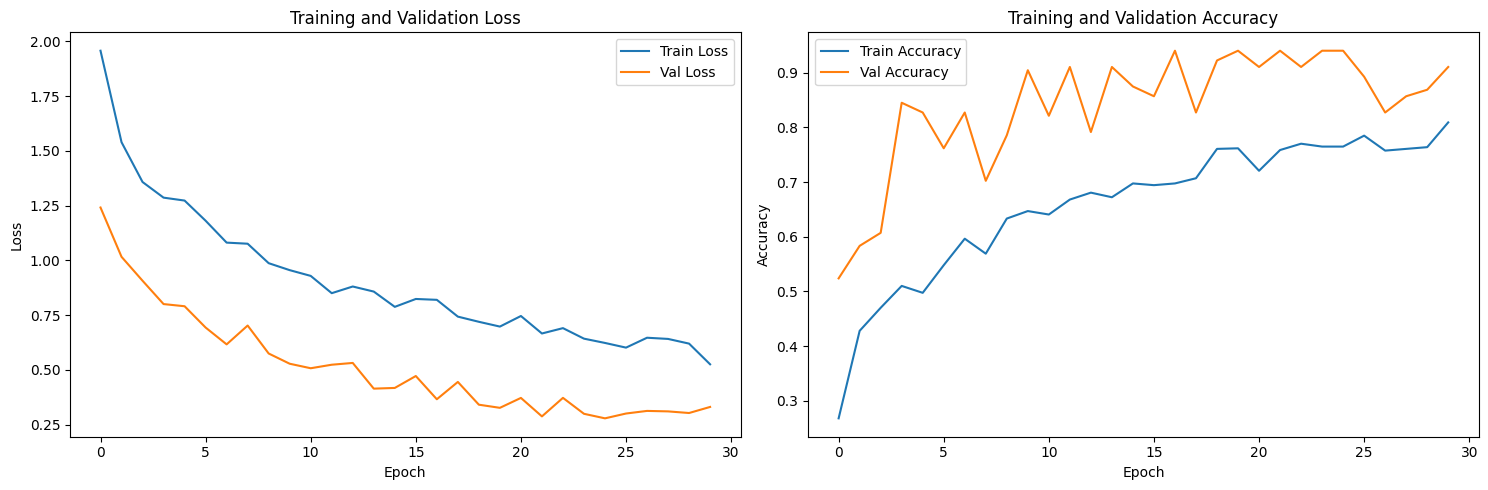

In [43]:
# Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(val_accs, label='Val Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.tight_layout()
plt.show()

In [44]:
# Save Model Information
def save_model_info(model, class_names, save_path):
    """Save model information for later use"""
    model_info = {
        'class_names': class_names,
        'num_classes': len(class_names),
        'model_architecture': str(model),
        'input_size': 224
    }

    import json
    with open(save_path, 'w') as f:
        json.dump(model_info, f, indent=2)

model_info = {
    'class_names': class_names,
    'num_classes': len(class_names),
    'input_size': 224
}

import json
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print("Model information saved!")

Model information saved!


In [45]:
# Initialize the Complete Pipeline
yolo_model_path = '/content/drive/MyDrive/Cv_project/models/individual_products.pt'  # Replace with your trained YOLO model
cnn_model_path = '/content/best_lightweight_cnn.pth'  # Path to your trained CNN

# Create pipeline instance
pipeline = YOLOCNNPipeline(yolo_model_path, cnn_model_path, class_names)
print("Pipeline initialized successfully!")

Pipeline initialized successfully!


In [50]:
# Process a Single Image
image_path = '/content/drive/MyDrive/input_images/IMG-20250609-WA0019.jpg'  # test image path
detections, image = pipeline.detect_and_classify(image_path)

# Print results
print(f"Found {len(detections)} detections:")
for i, detection in enumerate(detections):
    print(f"Detection {i+1}:")
    print(f"  Bounding Box: {detection['bbox']}")
    print(f"  Subclass: {detection['subclass']}")
    print(f"  YOLO Confidence: {detection['yolo_confidence']:.3f}")
    print(f"  CNN Confidence: {detection['subclass_confidence']:.3f}")
    print(f"  Combined Confidence: {detection['combined_confidence']:.3f}")
    print()


image 1/1 /content/drive/MyDrive/input_images/IMG-20250609-WA0019.jpg: 480x640 81 objects, 28.2ms
Speed: 4.1ms preprocess, 28.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)
Found 81 detections:
Detection 1:
  Bounding Box: (np.int64(484), np.int64(99), np.int64(527), np.int64(246))
  Subclass: Magnum Gold
  YOLO Confidence: 0.870
  CNN Confidence: 0.613
  Combined Confidence: 0.534

Detection 2:
  Bounding Box: (np.int64(618), np.int64(102), np.int64(659), np.int64(249))
  Subclass: Magnum Gold
  YOLO Confidence: 0.866
  CNN Confidence: 0.578
  Combined Confidence: 0.501

Detection 3:
  Bounding Box: (np.int64(486), np.int64(454), np.int64(525), np.int64(583))
  Subclass: Magnum Gold
  YOLO Confidence: 0.866
  CNN Confidence: 0.555
  Combined Confidence: 0.481

Detection 4:
  Bounding Box: (np.int64(394), np.int64(97), np.int64(437), np.int64(243))
  Subclass: Magnum Black
  YOLO Confidence: 0.866
  CNN Confidence: 0.998
  Combined Confidence: 0.864

Detection 5:

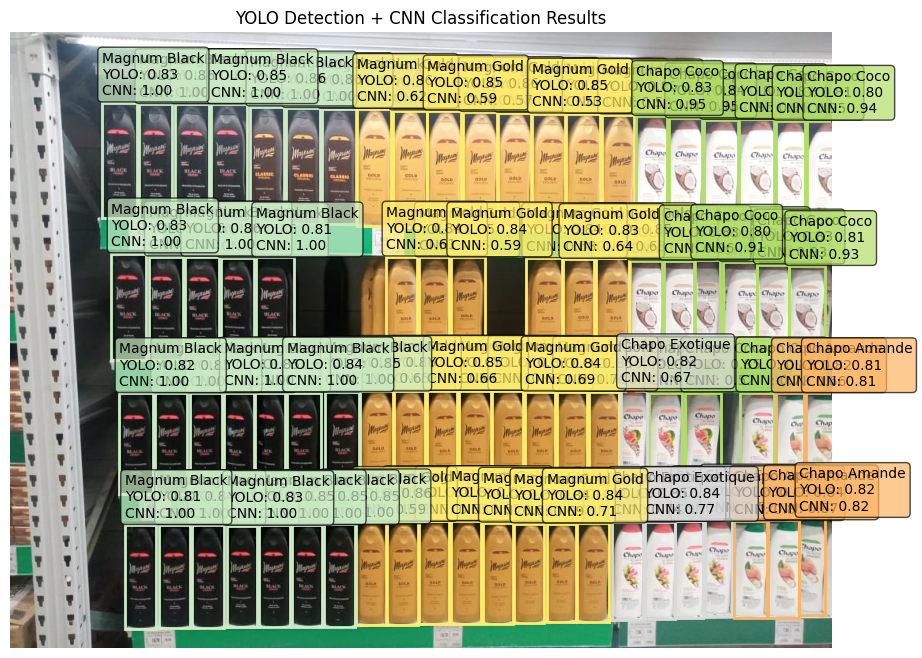

In [51]:
# Visualize Results
pipeline.visualize_results(image, detections, 'detection_results.png')